In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import colorsys
from math import pi, ceil, floor, cos, sin
import glob
import pandas as pd
#pip install plotly==5.3.1
from ipynb.fs.full.ploty_zoom import zoom

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

_root       = "./samples/"
NORMAL     = 1
AGLOMERADO = 0


directory = NORMAL

HEXAGONAL_MODE = False

UNET_ON_OTSU = False

In [48]:


def hexagon(img, pos, radius, color, line):

    def next_point(prev, line_length, angle):
        radians = angle * pi / 180
        return (int(prev[0] + line_length*cos(radians)),  
                int(prev[1] + line_length*sin(radians)))
    
    pts = [[pos[0]-radius,pos[1]]]
    pts.append(next_point(pts[0], radius, -60))
    pts.append(next_point(pts[1], radius, 0))
    pts.append(next_point(pts[2], radius, 60))
    pts.append(next_point(pts[3], radius, 120))
    pts.append(next_point(pts[4], radius, 180))

    pts = np.array(pts)
    pts = pts.reshape((-1,1,2))
    if line < 0:
        cv2.fillPoly(img,[pts],color)
    else:
        cv2.polylines(img,[pts],True,color, line)
    
    return img

def hexagon_cut(img):
    diam = img.shape[1]//3
    pos = (img.shape[1]//2,img.shape[0]//2)
    mask = np.zeros(img.shape, dtype='uint8')
    if len(img.shape) == 3:
        color = (1,1,1)
    else:
        color = 1
    
    mask = hexagon(mask, pos, diam, color, -1)
    
    img *= mask
    
    return img


Errors: 0


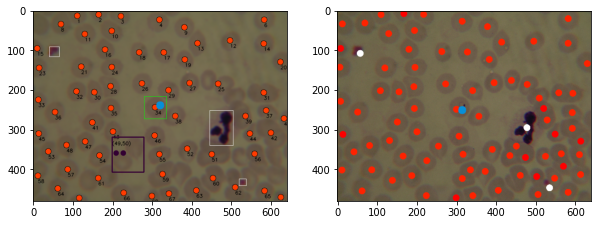

In [49]:
def not_yellow_random_color():
    color = np.random.randint(1,256, size=3)
    hsv = colorsys.rgb_to_hsv(color[0],color[1],color[2])
    if 30 <= hsv[0] <= 90:
        return not_yellow_random_color()
    return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_parasites_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
    
    manual = manual.copy()
    img = img.copy()
    
    if HEXAGONAL_MODE:
        manual = hexagon_cut(manual)
    if HEXAGONAL_MODE:
        img = hexagon_cut(img)
    
    #encontra as marcações relacionadas
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    for i in range(total_count1):
        if stats1[i, cv2.CC_STAT_AREA] > 1000:
            continue
        for y in range(total_count2):
            if stats2[y, cv2.CC_STAT_AREA] > 1000:
                continue
            
            dist = np.linalg.norm(centroids1[i]-centroids2[y])
            if dist < 30:
                color = not_yellow_random_color()
                cX, cY = centroids1[i]
                cv2.circle(img, (int(cX),int(cY)), 10, color, -1)
                cX, cY = centroids2[y]
                cv2.circle(manual, (int(cX),int(cY)), 10, color, -1)
                
                
    #conta quantas marcações amarelas sobraram
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    errors = 0
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    
#     plt.imshow(img_mask)
#     plt.show()
#     plt.imshow(manual_mask)
#     plt.show()
    errors = total_count1 + total_count2 - 2
    
    return errors, img, manual


if __name__ == "__main__":
    manual = "./samples/normal/blood_smear_1_count.JPG"
    #manual = "./samples/normal/blood_smear_7_count.JPG"
    manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img = "./samples/segmented/blood_smear_1_otsu.png"
    #img = "./samples/normal/blood_smear_7_segmented.png"
    img    = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_parasites_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

Errors: 3


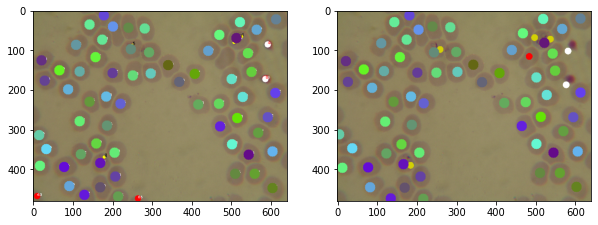

In [50]:


def get_img(name):
    if HEXAGONAL_MODE:
        return hexagon_cut(cv2.imread(name,1))
    else:
        return cv2.imread(name,1)
    
    
def not_red_random_color():
    color = np.random.randint(1,256, size=3)
    color[0] = 100
    if (color[1] < 100 and color[2] < 100):
        return not_red_random_color()
    elif (color[1] > 230 and color[2] > 230):
        return not_red_random_color()
    else:
        return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
        
    manual = manual.copy()
    img = img.copy()
        
    if HEXAGONAL_MODE:
        manual = hexagon_cut(manual)
    if HEXAGONAL_MODE:
        img = hexagon_cut(img)
    
        
    errors = 0
    total = 0
    manual_total = 0
    max_area = 300#despreza as marcações das bordas
    min_area = 100
    
    #procura por todas as marcacoes que estejam em posicoes similares nas duas imagens
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_count, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total += total_count - 1
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_count, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_total += manual_count -1
    
    #print("total", total, "manual_total", manual_total)
    
    
    #das celulas restantes procuro a marcação relacionada
    for m_c in manual_centroids:
        i = 0
        for c in centroids:
            dist = np.linalg.norm(c-m_c)
            if dist < 20 and stats[i, cv2.CC_STAT_AREA] < max_area:
                cX, cY = m_c
                color = not_red_random_color()
                cv2.circle(manual, (int(cX),int(cY)), 13, color, -1)
                cX, cY = c
                cv2.circle(img, (int(cX),int(cY)), 13, color, -1)
                break
            i += 1
        
    
    #conta as células que estao agrupadas
    #relacionando com as posicoes na contagem manual
    
    
    def has_more_groups(img, color):
        mask = cv2.inRange(img, (color,0,color), (255,0,255))
        return np.sum(mask)

    color = 50

    
    while (has_more_groups(img, color)):
        #encontra a caixa        
        mask = cv2.inRange(img, (color+2,0,color+2), (color+2,0,color+2))
        
        #preenche as bordas falhadas do retangulo
        image = img_as_bool(mask)
        out = ndi.distance_transform_edt(~image)
        out = out < 0.05 * out.max()
        out = morphology.skeletonize(out)
        out = morphology.binary_dilation(out) #, morphology.footprints) #morphology.selem.disk(1)
        out = segmentation.clear_border(out)
        out = out | image
        mask[out] = 255
        
        #encontra o retangulo que envolve as celulas
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        max_area = 0
        sel = 0
        for c in range(len(cnts)):
            area = cv2.contourArea(cnts[c])
            if max_area < area:
                max_area = area
                sel = c
        x,y,w,h = cv2.boundingRect(cnts[sel])
        #cv2.rectangle(mask, (x,y), (x+w,y+h), 255, 3)
            
        
        #contagem das celulas encontradas pelo algoritmo
        #conta as celulas da cor da caixa
        mask_cells = cv2.inRange(img, (color,0,color), (color,0,color))
        box_count, _, _, _ = cv2.connectedComponentsWithStats(mask_cells, 4, cv2.CV_32S)
        #conta as celulas vermelhas ainda dentro da caixa
        img_cut = img[y:y+h,x:x+w]
        hsv = cv2.cvtColor(img_cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        
        cell_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                center = centroids[i]
                cell_count += 1
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(img, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        cell_count += box_count-1
        
        
        
        #conta as celulas dentro da caixa na contagem manual
        cut = manual[y:y+h,x:x+w]
        hsv = cv2.cvtColor(cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        max_area = 300
        min_area = 100
        manual_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                manual_count += 1
                center = centroids[i]
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(manual, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        
        
        mask_cells = mask_cells[y:y+h,x:x+w]
        
        total        += cell_count
        manual_total += manual_count
        #print("count",cell_count, "manual",manual_count)
        
        errors += abs(cell_count - manual_count)
        
        color += 5

        
    #conta quantas marcacoes vermelhas sobraram em ambas
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_error, _, _, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total_error -= 1
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_error, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_error -= 1
    
    errors += total_error + manual_error
    
    
    return errors, img, manual


if __name__ == "__main__":
    #87 semar_8
    #95 manual
    manual = cv2.cvtColor(cv2.imread("./samples/normal/blood_smear_7_count.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img    = cv2.cvtColor(cv2.imread("./samples/normal/blood_smear_7_segmented.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

Errors: 33


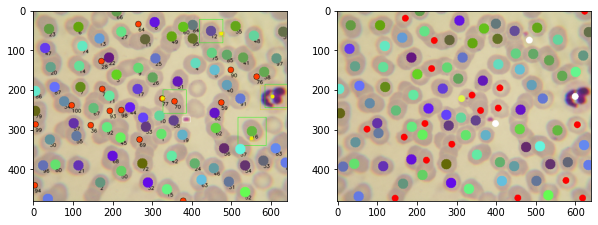

In [51]:
#87 semar_8
#95 manual
if __name__ == "__main__":

    manual = cv2.cvtColor(cv2.imread("./samples/aglomerado/blood_smear_8_count.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img    = cv2.cvtColor(cv2.imread("./samples/segmented/blood_smear_8_hough.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

In [52]:
def getManualCount(name):
    return {"method":"Manual", "path":name, "time":0}


def getOriginalCount(directory,name):
    name1 = name.replace(directory,_root+"result/") + "_resultText.txt"
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    
    return {"method"  :"Original",
            "time"    :float(data[4]),
            "path"    :name+"_segmented.png"}

def getProjectCount(directory,name):
    name = name.replace(directory,_root+"myresults/") + "_result.txt"
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        data = lines[i].split("\t")
        if len(data) > 1:
            ret.append({
                'method'  : data[0].strip(),
                'time'    : float(data[4].strip().replace("s","")),
                'path'    : data[5].strip(),
            })
    return ret


def add_to_samples(samples,values):
    if "cells_error" not in values.keys():
        values['cells_error'] = -1
    if "infection_error" not in values.keys():
        values['infection_error'] = -1
        
    if (UNET_ON_OTSU):
        values["method"] = values["method"].replace("OTSU","UNET")
    
    samples['method'].append(values["method"])
    samples['time'].append(values["time"])
    samples['path'].append(values["path"])
    samples['cells_error'].append(values["cells_error"])
    samples['infection_error'].append(values["infection_error"])

    
    
def read_result_data(group):
    
    if group == AGLOMERADO:
        directory = "./samples/aglomerado/"
    else:
        directory = "./samples/normal/"

    samples = {"sample":[],
               "method":[],
               "time":[],
               "path":[],
               "infection_error":[],
               "cells_error":[]}

    qtd = 0
    for file in glob.glob(directory+"*_count.jpg"):
        qtd += 1
        
        #nome da amostra
        file = file.replace("\\","/").lower()
        name = file.replace("_count.jpg","")
        sample_name = name.replace(directory,"")
        samples['sample'].append(sample_name)

        #adiciona os dados do Ground truth a base
        manual = getManualCount(file)
        add_to_samples(samples,manual)

        #le os dados obtidos pelo projeto
        data = getProjectCount(directory, name)
        for dt in data:
            #adiciona na base
            samples['sample'].append(sample_name)
            dt['cells_error'], _, _ = compare_markers(file, dt['path'])
            dt['infection_error'], _, _ = compare_parasites_markers(file, dt['path'])
            add_to_samples(samples,dt)

            
        #le os dados do projeto original
        orig = getOriginalCount(directory, name)
        samples['sample'].append(sample_name)
        print("reading",orig['path'])
        orig['cells_error'], _, _ = compare_markers(file, orig['path'])
        orig['infection_error'], _, _ = compare_parasites_markers(file, orig['path'])
        #adiciona na base
        add_to_samples(samples,orig)

    samples = pd.DataFrame(data=samples)
    return samples

if __name__ == "__main__":
    samples = read_result_data(directory)
    samples

reading ./samples/normal/blood_smear_11_segmented.png
reading ./samples/normal/blood_smear_15_segmented.png
reading ./samples/normal/blood_smear_18_segmented.png
reading ./samples/normal/blood_smear_1_segmented.png
reading ./samples/normal/blood_smear_2_segmented.png
reading ./samples/normal/blood_smear_30_segmented.png
reading ./samples/normal/blood_smear_3_segmented.png
reading ./samples/normal/blood_smear_4_segmented.png
reading ./samples/normal/blood_smear_5_segmented.png
reading ./samples/normal/blood_smear_6_segmented.png
reading ./samples/normal/blood_smear_7_segmented.png


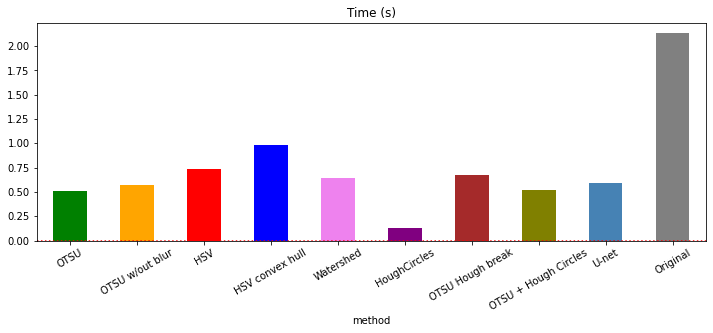

In [53]:
def graph(smp_name,value):
    smp = samples.query("method != 'Manual'  & sample == '%s'"%smp_name)
    ax = smp[["method",value]].plot.bar(x='method',
                                        y=value,
                                        color=['green','orange','red',
                                               'blue','violet','purple',
                                               'brown', 'olive','steelblue', 'gray'],
                                        title=smp_name,
                                        figsize=(12,4),
                                        rot=30)
    manual_count = samples.query("method == 'Manual' & sample == '%s'" % smp_name).iloc[0][value]


    ax.axhline(y=manual_count, color='r', linestyle='dotted')
    ax.get_legend().remove()
    
    plt.title('Time (s)')
    
if __name__ == "__main__":
    graph(samples['sample'].iloc(0)[0],"time")

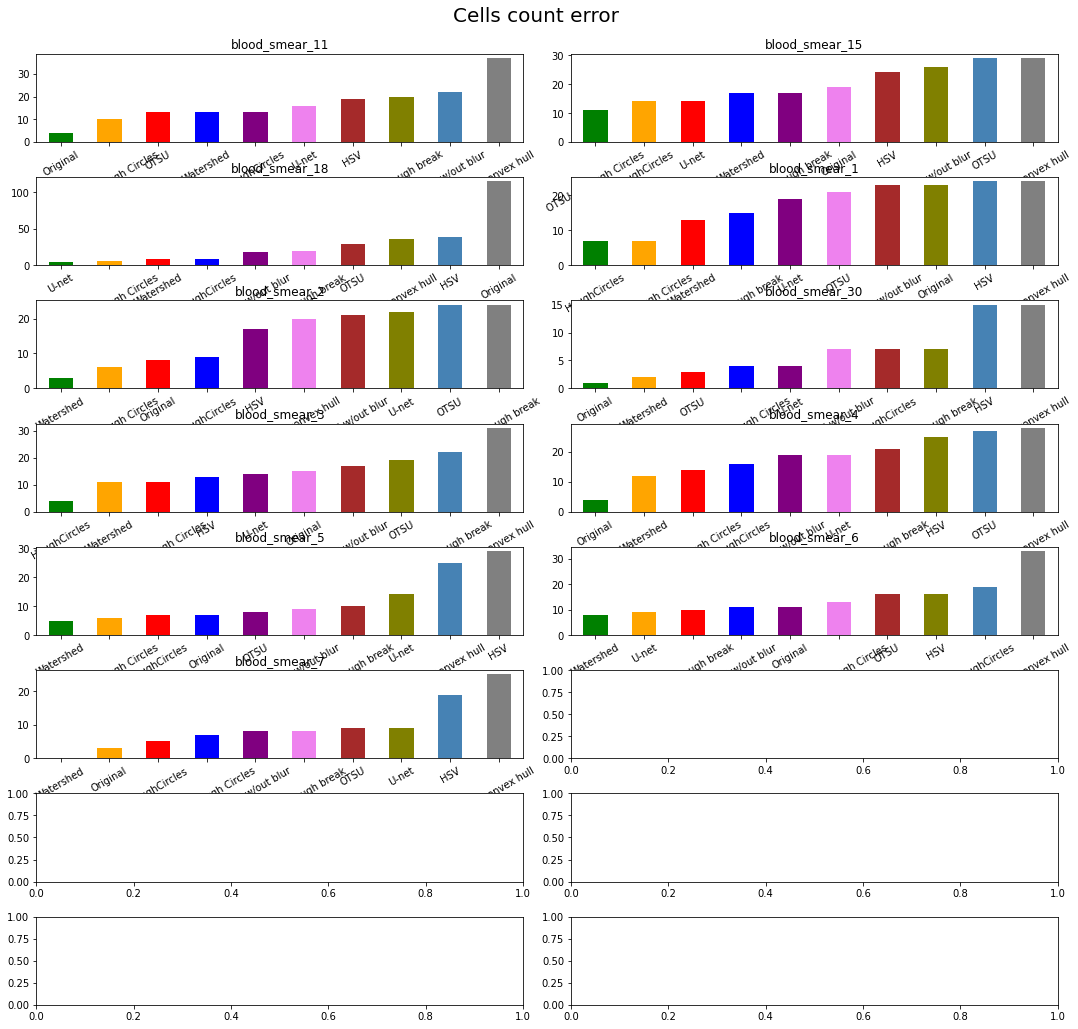

In [54]:
if __name__ == "__main__":

    samples_list = samples[["sample"]].drop_duplicates().values
    samples_list = samples_list.reshape(len(samples_list))

    fig, axes = plt.subplots(ncols=2,nrows=8,figsize=(15,15))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle("Cells count error", fontsize=20)
    plt.subplots_adjust(hspace = .4)

    pos = [(j,i) for j in range(8) for i in range(2)]
    i = 0
    for smp_name in samples_list:

        smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
        smp = smp.sort_values('cells_error')
        ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                    y='cells_error',
                                                    color=['green','orange','red',
                                                           'blue','purple','violet',
                                                           'brown', 'olive','steelblue', 'gray'],
                                                    ax=axes[pos[i]],
                                                    title=smp_name,
                                                    rot=30)
        ax.get_legend().remove()
        ax.set_xlabel('')
        i += 1



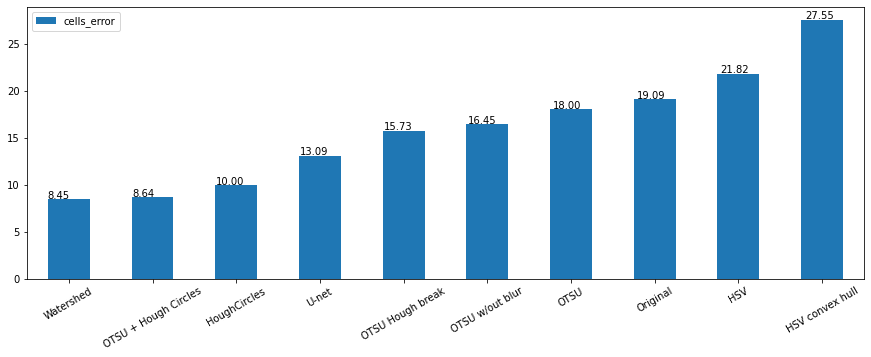

In [55]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","cells_error"]].groupby("method").mean().sort_values("cells_error")
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.2f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

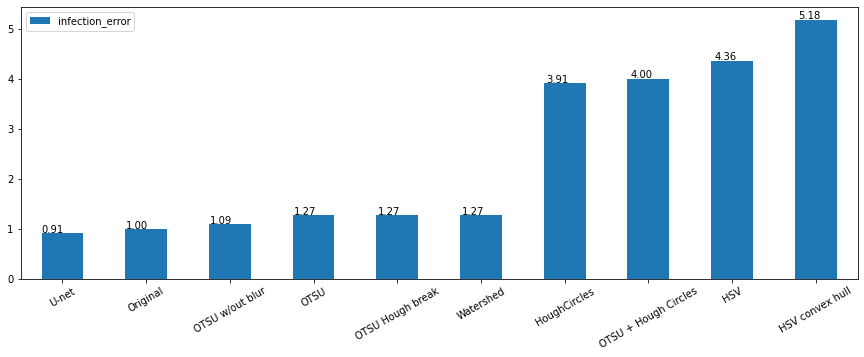

In [56]:
if __name__ == "__main__":
    smp = samples.query("method != 'Manual'")
    smp = smp[["method","infection_error"]].groupby("method").mean().sort_values("infection_error")
    #smp
    ax = smp.plot.bar(figsize=(15,5),rot=30)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate("%.2f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

IndexError: index 6 is out of bounds for axis 0 with size 6

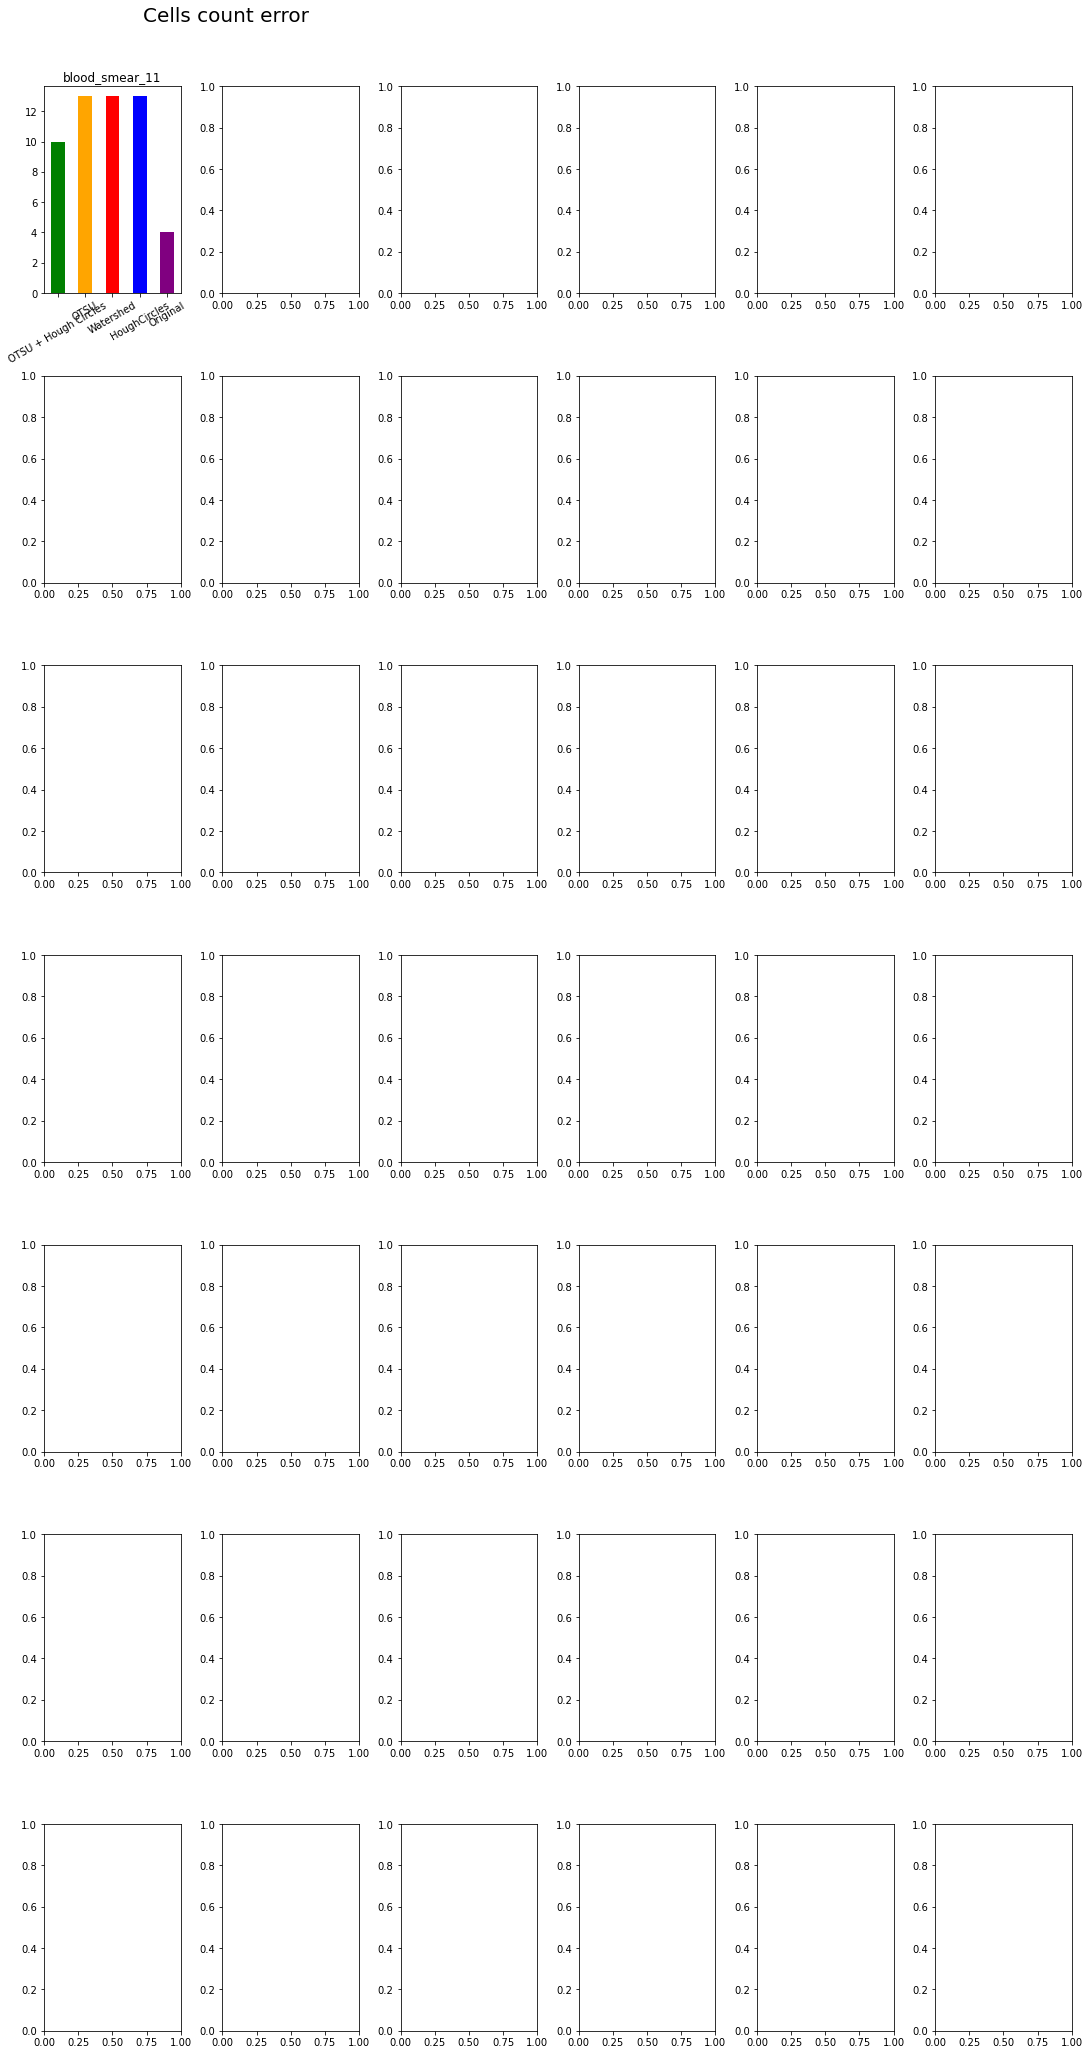

In [57]:
if __name__ == "__main__":
    samples_list = samples[["sample"]].drop_duplicates().values
    samples_list = samples_list.reshape(len(samples_list))

    #methods
    cols = 6 #1-8 max
    #samples
    rows = 7


    fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(30,30))
    fig.tight_layout(rect=[0, .03, 0.5, 0.95])
    fig.suptitle("Cells count error", fontsize=20, x=0.1)
    plt.subplots_adjust( hspace=0.4 )

    pos = [(j,i) for j in range(rows) for i in range(cols)]
    i = 0
    for smp_name in samples_list:

        smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
        smp = pd.concat([smp.query("method != 'Original'").nsmallest(cols-2,'cells_error'),
                         smp.loc[smp['method'] == "Original"]])
        ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                    y='cells_error',
                                                    color=['green','orange','red','blue','purple'],
                                                    ax=axes[pos[i]],
                                                    title=smp_name,
                                                    rot=30)
        ax.get_legend().remove()
        ax.set_xlabel('')
        i += 1

        for v in smp.values:
            img = cv2.cvtColor(cv2.imread(v[6]),cv2.COLOR_BGR2RGB)
            axes[pos[i]].set_title(v[1])
            axes[pos[i]].imshow(img)
            axes[pos[i]].axis('off')
            i += 1

    plt.savefig("tmpa4.png",dpi=300)
    plt.close()
    #sometimes it make a cache of image
    #change the image name
    zoom("tmpa4.png")


# HoughCircles x Original

In [ ]:
if __name__ == "__main__":
    smp = samples.query("method in ['Watershed','Union','Original']")


    k = 0
    for v in smp.values:
        if k == 0:
            fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(20,12))
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fig.suptitle(v[0],fontsize=20)
        img = cv2.cvtColor(cv2.imread(v[6]),cv2.COLOR_BGR2RGB)
        
        manual_path = samples.query("method == 'Manual' & sample == '%s'" % v[0])
        manual_path = manual_path['path'].iloc(0)[0]
        seg_path    = v[6]
        error, img, manual = compare_markers(manual_path, seg_path)

        axes[0][k].set_title(v[1]+ " error:%d" % (v[7]))
        axes[0][k].imshow(img)
        axes[1][k].imshow(manual)
        axes[0][k].axis('off')
        axes[1][k].axis('off')
        k += 1
        if k == 3:
            plt.show()
            k = 0